# MSCF 46982 Market Microstructure and Algorithmic Trading

Fall 2025 Mini 2

Introduction to Crypto Level 1

Copyright &copy; 2025 Nick Psaris. All Rights Reserved

# TOC
- [Attribution](#Attribution)
- [Initialize](#Initialize)
- [Tables](#Tables)
- [Top Currency Pairs](#Top-Currency-Pairs)
- [Top Exchanges](#Top-Exchanges)
- [Transaction Rate, Volume, Roll Spread and Volatility Profiles](#Transaction-Rate,-Volume,-Roll-Spread-and-Volatility-Profiles)
- [Depth, Spread and Imbalance Profiles](#Depth,-Spread-and-Imbalance-Profiles)

# Attribution
- Market data provided by [ICE Data Services][]
- Crypto data feed sourced from [Blockstream][]
- **Any saved or downloaded data must be immediately removed from
  personal devices after completion of the course**

[ICE Data Services]: https://www.theice.com/market-data/cryptocurrencies "Ice Data Services"
[Blockstream]: https://blockstream.com/cryptofeed "Blockstream"

# Initialize
- We start by initializing the number of rows and columns displayed
- Then create connection to the crypto data L1 Kdb+ server
- And finally, initialize the python environment

In [1]:
import os
os.environ['PYKX_JUPYTERQ'] = 'true'
os.environ['PYKX_4_1_ENABLED'] = 'true'
import pykx as kx


PyKX now running in 'jupyter_qfirst' mode. All cells by default will be run as q code. 
Include '%%py' at the beginning of each cell to run as python code. 


In [2]:
\c 15 120
/ windows and mac/linux use different environment variables
home:`HOME`USERPROFILE "w"=first string .z.o
upf:0N!` sv (hsym`$getenv home),`cmu_userpass.txt
h:`$":tcps://tpr-mscf-kx.tepper.cmu.edu:5002:",first read0 upf
pivot:{[t]
 u:`$string asc distinct last f:flip key t;
 pf:{x#(`$string y)!z};
 p:?[t;();g!g:-1_ k;(pf;`u;last k:key f;last key flip value t)];
 p}

`:/Users/nick/cmu_userpass.txt


In [3]:
%%py
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('default')
mpl.rcParams["figure.figsize"] = [15,5]


# Tables
- The ``ccy`` table maps the three-letter currency code to the full
  name
- The ``ex`` table maps the three-letter crypto exchange code to the
  full name
- The ``daily`` table provides a daily summary of each token
- The ``quote`` table provides top-of-book (L1) quotes at both the
  exchange level as well as on an aggregated basis
- The ``trade`` table contains all trades from that Blockstream has
  been able to aggregate


In [4]:
h"tables[]"

`ccy`cryptomas`daily`ex`handle`mas`nbbo`opracode`opracols`opradmm`opratrade`quote`trade


## Tables combine exchange-level and consolidated feeds

In [5]:
`price xdesc h"select from daily where date=first date,sym like \"*XBTUSD*\""

date       sym           open     high     low      close    price        size     n     
-----------------------------------------------------------------------------------------
2023.12.01 X:SXBTUSD     37765    40989    37602.6  38737.09 3.708512e+08 9643.638 259260
2023.12.01 X:SXBTUSD@BTS 37745.7  38975.1  37602.6  38698.4  1.795818e+08 4675.038 142016
2023.12.01 X:SXBTUSD@BFX 37755    38979    37618    38701    1.01964e+08  2649.067 27160 
2023.12.01 X:SXBTUSD@BST 37765    39000    37619    38719    6.264657e+07 1629.868 13839 
2023.12.01 X:SXBTUSD@GEM 37757.5  38998.12 37603.51 38737.09 1.288599e+07 335.144  8786  
2023.12.01 X:SXBTUSD@ITB 37780.75 38991    37629.75 38726.25 7032383      182.8227 58599 
2023.12.01 X:SXBTUSD@EXM 39595.04 40989    39555.4  40317.8  3550629      88.88384 3624  
2023.12.01 X:SXBTUSD@BSO 37771    38960    37607    38726    2687255      69.71418 4499  
2023.12.01 X:SXBTUSD@BFL 37714.03 38888.5  37683.13 38755.98 366927.9     9.569767 317   
2023.12.01

# Top Currency Pairs
- The ``0:`` operator an be used for fixed-width parsing (we use it
  instead of string indexing to extract components from the symbol
- The q ``like`` operator understands a limited regular expression
  syntax. e.g., ? (for a single character), * for a list of characters
  and [a-zA-Z] for a specific or range or specific characters.


In [6]:
topccy:{[symres]
 t:0!select sum price*1e-9, sum n by sym from daily where any sym like/: symres;
 t:t,'flip `baseccy`quoteccy!(" SS";3 3 3) 0: string t`sym;
 t:t lj 1!`baseccy`basedescr xcol ccy;
 t:t lj 1!`quoteccy`quotedescr xcol ccy;
 t:2!`price xdesc select baseccy,quoteccy,basedescr,quotedescr,price,n from t;
 t}
h (topccy;("X:S???*US[DT]";"X:S???*UDC"))

baseccy quoteccy| basedescr   quotedescr price    n       
----------------| ----------------------------------------
XBT     UST     | "Bitcoin"   "USD"      82.08924 83603353
ETH     UST     | "Ether"     "USD"      47.34919 37936970
SOL     UST     | "Solana"    "USD"      28.71803 36316600
UDC     UST     | "USD"       "USD"      14.79216 8311283 
AVA     UST     | "Avalanche" "USD"      10.20062 21636196
XRP     UST     | "Ripple"    "USD"      9.901433 15635129
BNB     UST     | "BINANCE"   "USD"      9.400714 15625023
XBT     UDC     | "Bitcoin"   "USD"      9.203799 7837428 
XBT     USD     | "Bitcoin"   "United"   9.11221  6354205 
ETH     UDC     | "Ether"     "USD"      7.376101 7496919 
..


# Top Exchanges

In [7]:
topex:{[symres]
 t:0!select sum price*1e-9, sum n by sym from daily where any sym like/: symres;
 t:t,'flip `baseccy`quoteccy`ex!(" SS S";3 3 3 1 3) 0: string t`sym;
 t:t lj 1!`baseccy`basedescr xcol ccy;
 t:t lj 1!`quoteccy`quotedescr xcol ccy;
 t:3!`price xdesc select baseccy,quoteccy,ex,basedescr,quotedescr,price,n from t;
 t}
`price xdesc select sum price, sum n by quoteccy,ex from h (topex;("X:S???*US[DT]@???";"X:S???*UDC@???"))

quoteccy ex | price    n        
------------| ------------------
UST      BIN| 195.6257 326782072
UST      OKX| 51.1632  60947113 
UST      HBI| 20.42532 215362821
UST      LBK| 18.51361 52368333 
USD      BTS| 9.560041 16186113 
UDC      LBK| 8.846431 20518442 
UST      KUC| 6.56645  31293587 
USD      BFX| 4.758872 2997655  
USD      BST| 3.433297 1276621  
UDC      OKX| 3.427683 6325258  
..


# Transaction Rate, Volume, Roll Spread and Volatility Profiles
- Functions such as the ``roll`` function below can be declared (and
  therefore scoped) within a function and sent to the server
- The numeric value 0 is considered false, while all other values are
  true

## Trade Conditions
| Value | Description           |
| -:    | -                     |
| 0     | Last eligible trade   |
| 1     | Last ineligible trade |
| 2     | Block trade           |


In [8]:
/ (sym)bol(s); x(bar); (d)a(t)e
trade:{[syms;bar;dt]
 roll:{2f*sqrt neg x scov prev x-:prev x};
 t:select size, price, sym, time, cond from trade where date = dt, sym in syms;
 t:select n:count i, o:first price, h:max price, l:min price, c:last price, size wsum price, esprd:roll[price]%size wavg price by sym, bar xbar time from t;
 t}

## Send analytics to the data!

In [9]:
syms:`$"X:S",/:raze string[`XBT`ETH`SOL],/:\:string[`USD`UST]
bar:0D00:15
t:raze (h (trade;syms;bar),0N!) each 2023.12.01 + til 31

2023.12.01
2023.12.02
2023.12.03
2023.12.04
2023.12.05
2023.12.06
2023.12.07
2023.12.08
2023.12.09
2023.12.10
2023.12.11
2023.12.12
2023.12.13
2023.12.14
2023.12.15
2023.12.16
2023.12.17
2023.12.18
2023.12.19
2023.12.20
2023.12.21
2023.12.22
2023.12.23
2023.12.24
2023.12.25
2023.12.26
2023.12.27
2023.12.28
2023.12.29
2023.12.30
2023.12.31


## Transaction Rate Profiles

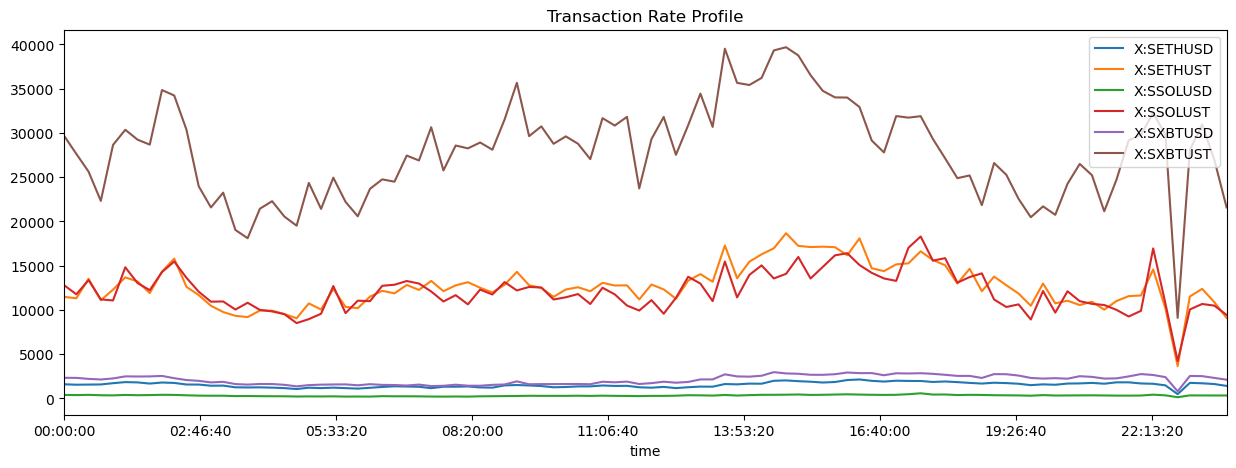

In [10]:
.pykx.set[`df] .pykx.topd pivot select avg n by "n"$time,sym from t
p)df.index=pd.to_timedelta(df.index)
p)df.plot(title='Transaction Rate Profile')

## Volume Profiles

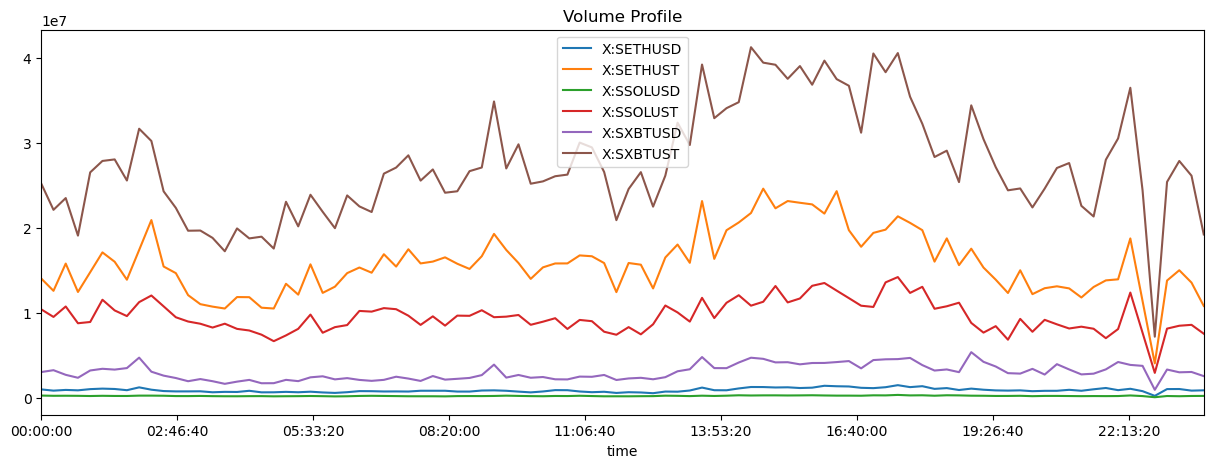

In [11]:
.pykx.set[`df] .pykx.topd pivot select avg price by "n"$time,sym from t
p)df.index=pd.to_timedelta(df.index)
p)df.plot(title='Volume Profile')

## Roll Spread Profiles

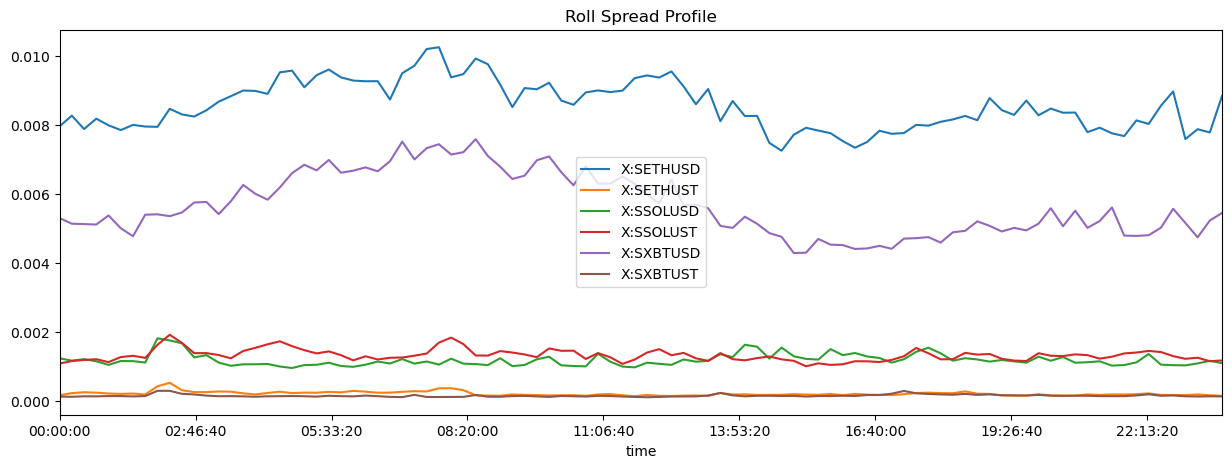

In [12]:
.pykx.set[`df] .pykx.topd pivot select avg esprd by "n"$time,sym from t
p)df.index=pd.to_timedelta(df.index)
p)df.plot(title='Roll Spread Profile')

## Garman Klass Yang Zhang Volatility
- Takes into account overnight jumps
- Assumes a Geometric Brownian Motion (GBM) with zero drift
- Will, therefore, overestimate volatility if the security has
  non-zero drift

$$
\sigma_{gkyz}^2=\left(\ln\frac{o_i}{c_{i-1}}\right)^2+\frac{1}{2}\left(\ln\frac{h_i}{l_i}\right)^2-(2\ln(2)-1)\left(\ln\frac{c_i}{o_i}\right)^2
$$


In [13]:
gkyz:{[o;h;l;c](x*x:log o%prev c)+(.5*x*x:log h%l)-(-1f+2f*log 2)*x*x:log c%o}

## Volatility Profiles


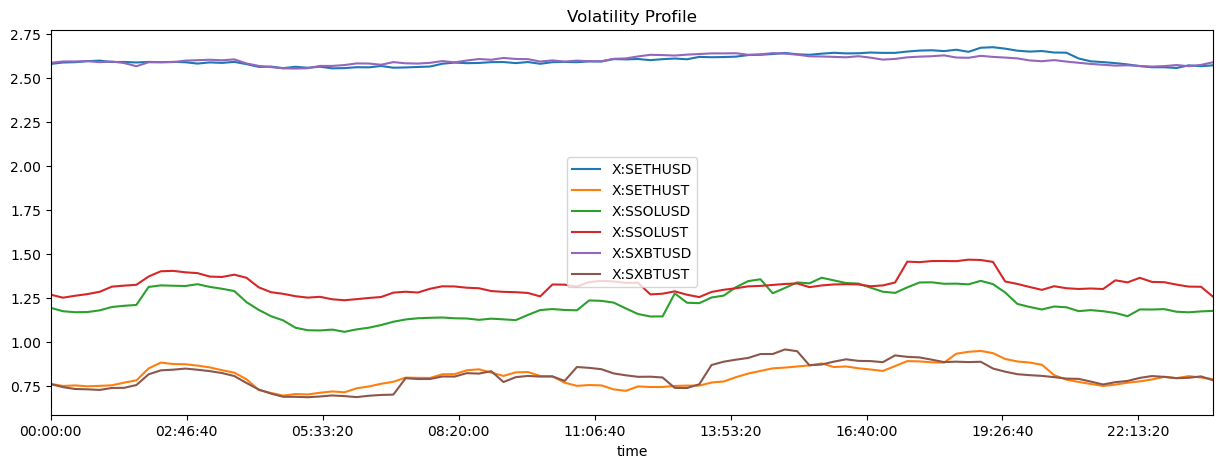

In [14]:
t:update variance:sqrt 356.25*(1D%bar)*("j"$0D02 div bar) mavg gkyz[o;h;l;c] by sym from t
.pykx.set[`df] .pykx.topd pivot select sqrt avg variance by "n"$time,sym from t
p)df.index=pd.to_timedelta(df.index)
p)df.plot(title='Volatility Profile')

# Depth, Spread and Imbalance Profiles
- By using ``exec`` we can compute multiple columns in a single function by returning a dictionary
- This allows us to reuse intermediate values

## Quote Conditions
| Value | Description                 |
| -:    | -                           |
| 0     | Normal (not Locked/Crossed) |
| 3     | One Sided Quote             |
| 54    | Locked                      |


In [15]:
/ (sym)bol(s); x(bar); (d)a(t)e
quote:{[syms;bar;dt]
 q:select sym,bid,ask,size:.5*bsize+asize,time from quote where date = dt, sym in syms, not cond;
 imbsprd:{[tm;b;a;s] durn:deltas[first tm;tm];mid:.5*ba:b+a;`imb`sprd`depth!durn wavg/:(b%ba;(a-b)%mid;s*mid)};
 q:exec imbsprd[time;prev bid;prev ask;prev size] by sym, bar xbar time from q;
 q}

## Send analytics to the data!

In [16]:
q:raze (h (quote;syms;bar),0N!) each 2023.12.01 + til 31

2023.12.01
2023.12.02
2023.12.03
2023.12.04
2023.12.05
2023.12.06
2023.12.07
2023.12.08
2023.12.09
2023.12.10
2023.12.11
2023.12.12
2023.12.13
2023.12.14
2023.12.15
2023.12.16
2023.12.17
2023.12.18
2023.12.19
2023.12.20
2023.12.21
2023.12.22
2023.12.23
2023.12.24
2023.12.25
2023.12.26
2023.12.27
2023.12.28
2023.12.29
2023.12.30
2023.12.31


## Depth Profiles

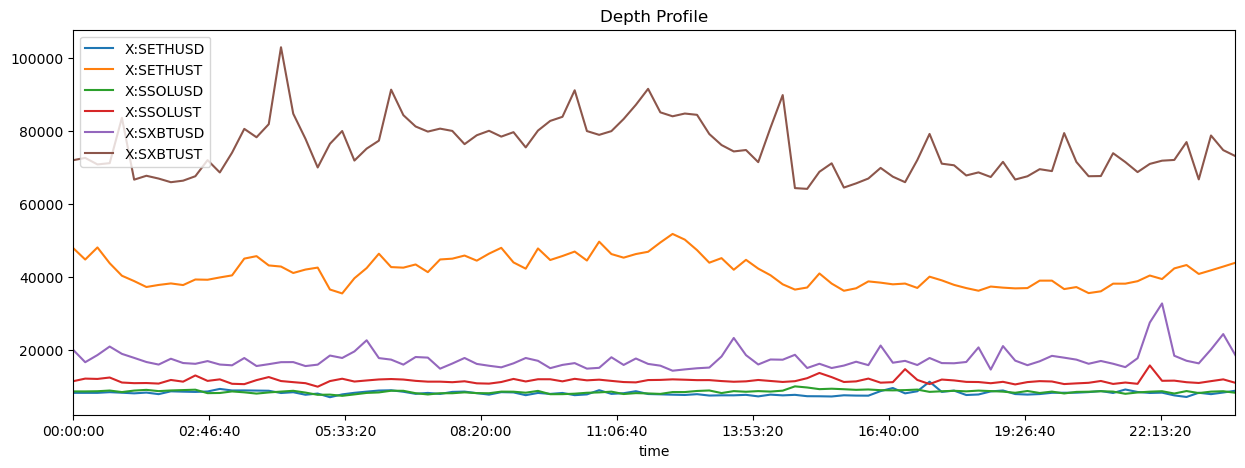

In [17]:
.pykx.set[`df] .pykx.topd pivot select avg depth by "n"$time,sym from q
p)df.index=pd.to_timedelta(df.index)
p)df.plot(title='Depth Profile')

## Spread Profiles

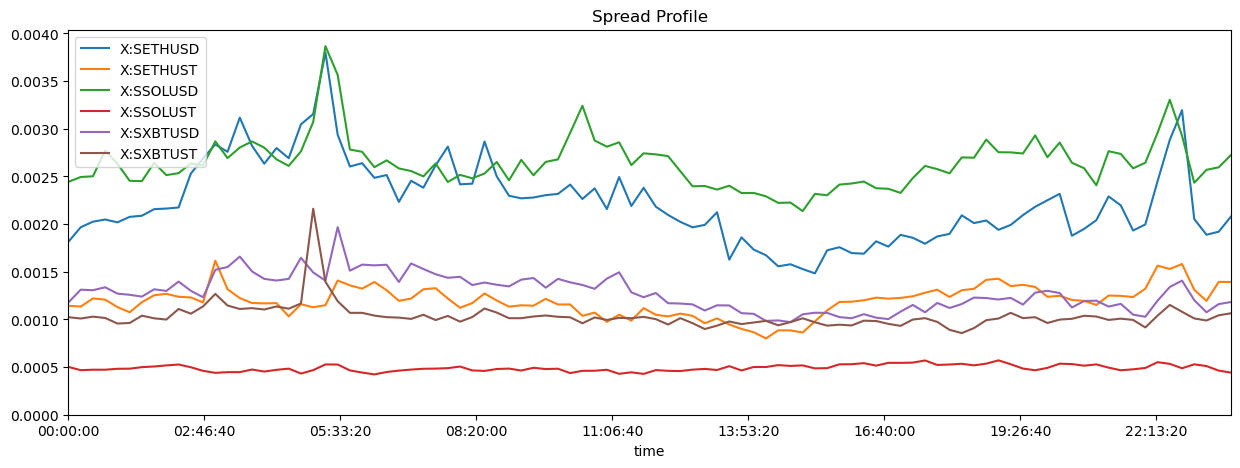

In [18]:
.pykx.set[`df] .pykx.topd pivot select avg sprd by "n"$time,sym from q
p)df.index=pd.to_timedelta(df.index)
p)df.plot(title='Spread Profile',ylim=(0))

## Imbalance Profiles

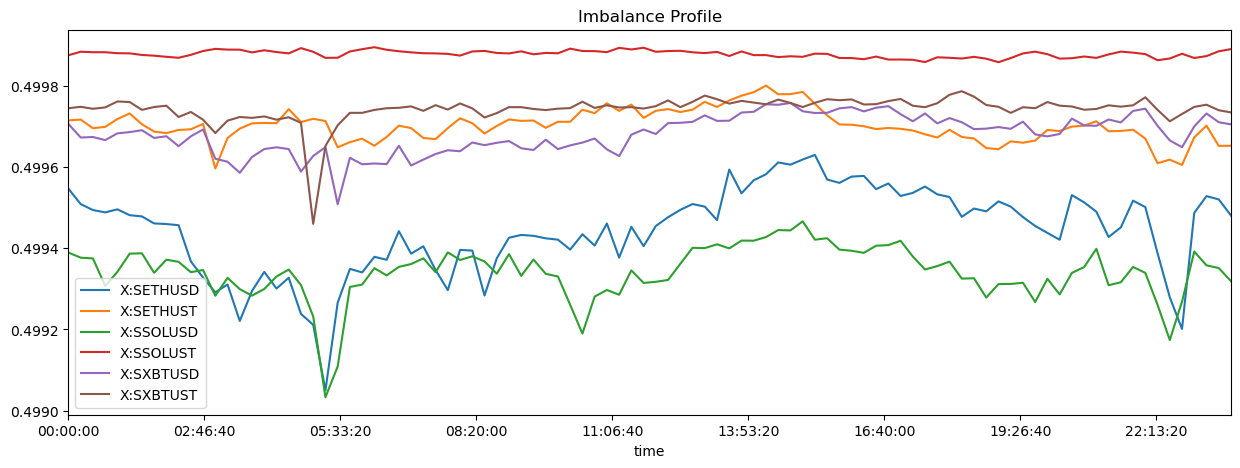

In [19]:
.pykx.set[`df] .pykx.topd pivot select avg imb by "n"$time,sym from q
p)df.index=pd.to_timedelta(df.index)
p)df.plot(title='Imbalance Profile')